# Final Project : Damien Amzallag, Skye Nadel

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; In our project we go through the Food and Drug Administration's extensive databases to answer questions about food and drug safety in the United States.  The database has an API that we used to navigate through the database obtaining the data that we wanted to answer our various questions. 

## First Question: Are dangerous drug recalls more common in some states than others?
- See if there are states that have an abnormal amount of recalls
- Analyze why these states have the most recalls

In [1]:
import requests
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import plotnine as gg
import seaborn as sns
from datetime import datetime
from dateutil.parser import parse
from IPython.display import display, HTML
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The first step was to find which states had the most recalls and upon doing this analysis we found that there was three different types of recalls.  

- Class 1 is the most dangerous and means that there is reasonable probability that using the drug will cause serious adverse health consequences or death.  

- Class 2 is the next tier and means that the drug may cause temporary or medical reversible adverse health consequences,  the probability of serious adverse health consequences is remote

- Class 3 is the last tier and means that using the drug is not likely to cause adverse health consequences.

Below are the results from this first look at the recalls data for each state

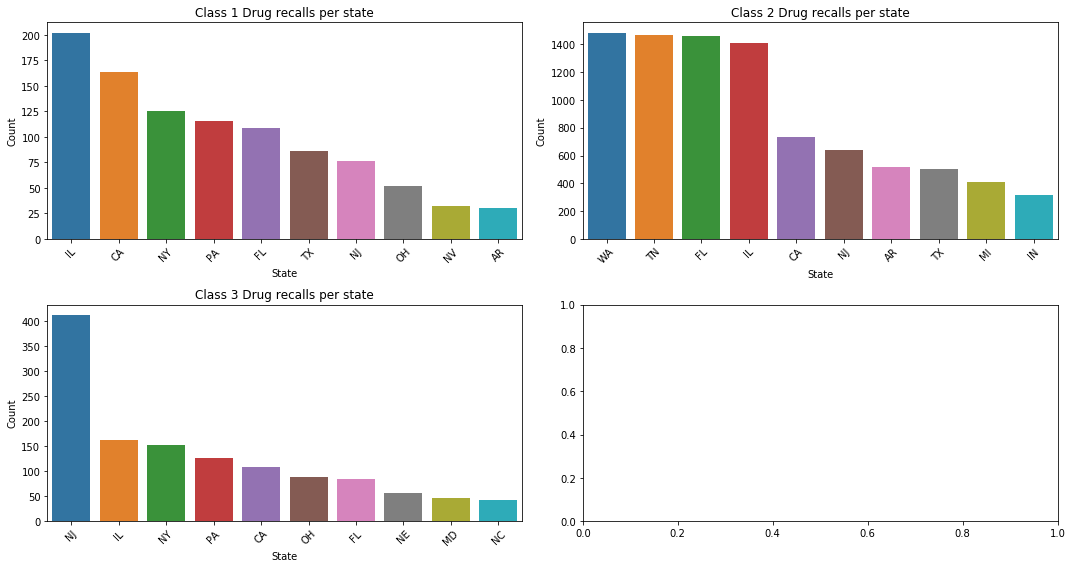

In [220]:
class1 = requests.get("""https://api.fda.gov/drug/enforcement.json?count=state&search=
                      classification:Class+I""")
class2 = requests.get("""https://api.fda.gov/drug/enforcement.json?count=state&search=
                      classification:Class+II""")
class3 = requests.get("""https://api.fda.gov/drug/enforcement.json?count=state&search=
                      classification:Class+III""")
js1 = class1.json()
js2 = class2.json()
js3 = class3.json()
#Use the three requests above to get the Class 1, 2, and 3 recalls for each state and convert to json.

recall_state_C2 = pd.DataFrame(js2['results'])
recall_state_C2["term"] = recall_state_C2["term"].str.upper()
    
recall_state_C1 = pd.DataFrame(js1['results'])
recall_state_C1["term"] = recall_state_C1["term"].str.upper()
    
recall_state_C3 = pd.DataFrame(js3['results'])
recall_state_C3["term"] = recall_state_C3["term"].str.upper()
#Convert to a dataframe for easier use, and capitalize each of the states as they came in lowercase(eg: ca->CA)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,8))
ax1 = sns.barplot(data = recall_state_C1, x = recall_state_C1["term"][0:10], y = recall_state_C1["count"], ax = ax1)
ax2 = sns.barplot(data = recall_state_C2, x = recall_state_C2["term"][0:10], y = recall_state_C2["count"], ax = ax2)
ax3 = sns.barplot(data = recall_state_C3, x = recall_state_C3["term"][0:10], y = recall_state_C3["count"], ax = ax3)
ax1.set_xticklabels = ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45)
ax2.set_xticklabels = ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45)
ax3.set_xticklabels = ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 45)
ax1.set(title = "Class 1 Drug recalls per state", xlabel = "State", ylabel = "Count")
ax2.set(title = "Class 2 Drug recalls per state", xlabel = "State", ylabel = "Count")
ax3.set(title = "Class 3 Drug recalls per state", xlabel = "State", ylabel = "Count")
#Plot all three of the bar plots on the same graph to see each next to each other
plt.tight_layout()

The above three graphs show the number of recalls since 2012 for each different type of class, and only the top 10 states are shown in the graphs above.  We can see that for Class 3 recalls New Jersey had significantly more recalls than any other state.  The next 5 states are some of the most populous states so it makes sense for them to have more recalls than smaller states.  For Class 2 recalls there are four states that have at least double the amount of recalls that all other states and these are Washington, Tennessee, Florida, and Illinois.  We are unsure as to why these four states in particular are much higher than all others, but for this analysis we decided to focus on the Class 1 recalls as they are the most dangerous and noteworthy medical consequences come of these.  

For Class 1 recalls Illinois is at the top of the list having over 200 Class 1 drug recalls.  Upon seeing these results the first further inquiry we had was to account for the population of each state in this analysis.  One way to do this was to take the number of recalls per state per capita and we found a dataset that contained the populations for each state in 2016 from census.gov.  The dataset came in an excel file and is loaded into jupyter in the box below this one.  The next step is to adjust for recalls per capita and look at the results of that.

In [221]:
#From census.gov
populations = pd.read_excel("populations.xlsx")
populations.columns = [list(populations.iloc[2])]

In [222]:
#For some reason Class 1 recalls would come with the class 2 recalls sometimes, so just got all the recalls and then
#found the drug_class we wanted
def state_class_recalls(state,drug_class, pages):
    C1_fullframe = pd.DataFrame(columns = ['address_1', 'address_2', 'center_classification_date', 'city',
       'classification', 'code_info', 'country', 'distribution_pattern',
       'event_id', 'initial_firm_notification', 'more_code_info',
       'openfda', 'postal_code', 'product_description',
       'product_quantity', 'product_type', 'reason_for_recall',
       'recall_initiation_date', 'recall_number', 'recalling_firm',
       'report_date', 'state', 'status', 'termination_date',
       'voluntary_mandated'])
    drug_class = str(drug_class)
    #Create an empty dataframe with all the right column names
    for i in range(0,100*pages,100):
        url2 = """https://api.fda.gov/drug/enforcement.json?search=state:""" + state + """&limit=100&skip=""" + str(i)
        class1_il2 = requests.get(url2)
        class1_il_json2 = class1_il2.json()
        attempt2 = class1_il_json2["results"]
        attempt2 = pd.DataFrame(attempt2)
        #can only get 100 reports at a time but can skip reports, so make the appropriate amount of requests getting 100 every time
        C1_fullframe = C1_fullframe.append(attempt2)
        C1_fullframe = C1_fullframe.drop_duplicates("recall_number")
        #Lots of duplicate reports so drop those that are duplicates
    C1_fullframe = C1_fullframe[C1_fullframe["classification"]==drug_class]
    return(C1_fullframe)

california = state_class_recalls(state= "ca",pages = 10, drug_class = "Class I")
illinois = state_class_recalls(state = "il",pages = 18, drug_class = "Class I")
newyork = state_class_recalls(state = "ny",pages = 6, drug_class = "Class I")
pennsylvania = state_class_recalls(state = "pa",pages = 6, drug_class = "Class I")
florida = state_class_recalls(state = "fl",pages = 17, drug_class = "Class I")
#These were the top 5 from the above graphs

texas = state_class_recalls(state= "tx",pages = 7, drug_class = "Class I")
newjersey = state_class_recalls(state = "nj",pages = 12, drug_class = "Class I")
ohio = state_class_recalls(state = "oh",pages = 3, drug_class = "Class I")
nevada = state_class_recalls(state = "nv",pages = 3, drug_class = "Class I")
arizona = state_class_recalls(state = "ar",pages = 6, drug_class = "Class I")
utah = state_class_recalls(state = "ut",pages = 1, drug_class = "Class I")
#These were the next 6 from the above graphs

When doing this analysis there were a few complications:
-  When requesting from the FDA API there is a limit to 100 reports
-  The search parameter for Class 1 recalls still had some Class 2 reports included
-  There were countless duplicate reports, sometimes up to 5 duplicates of the same report

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; To battle these two complications we first used this 100 report limit, but also used the skip parameter which skips the first n reports.  If use a loop and change skip by 100 everytime we can get all of the reports for each state we want.  We got all the reports because using the FDA's filter for Class didn't work correctly as it turns out, and with all the reports we filtered with our own criteria and this worked correctly.  Lastly we dropped all duplicate reports so that each report is only shown once.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Next step is to create a new dataframe with the number of reports given by the FDA, and the population from the populations excel file.  Unfortunately the populations excel sheet had the state names spelled out and the FDA only had the abbreviations so there was no simple way of equating the two so we did it manually for the first 11 states since they had over 20 reports.

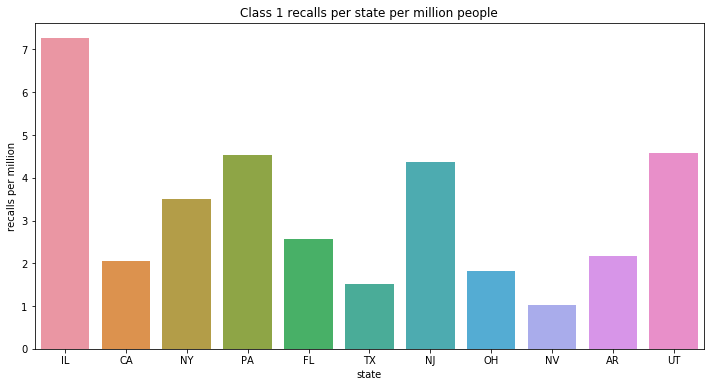

In [189]:
class_1 = pd.DataFrame(columns = ["state", "Class1_recalls", "population"])
class_1.loc[0] = ["IL", len(illinois),populations.iloc[21,9]]
class_1.loc[1] = ["CA", len(california),populations.iloc[12,9]]
class_1.loc[2] = ["NY", len(newyork),populations.iloc[40,9]]
class_1.loc[3] = ["PA", len(pennsylvania),populations.iloc[46,9]]
class_1.loc[4] = ["FL", len(florida),populations.iloc[17,9]]
class_1.loc[5] = ["TX", len(texas),populations.iloc[51,9]]
class_1.loc[6] = ["NJ", len(newjersey),populations.iloc[38,9]]
class_1.loc[7] = ["OH", len(ohio),populations.iloc[43,9]]
class_1.loc[8] = ["NV", len(nevada),populations.iloc[36,9]]
class_1.loc[9] = ["AR", len(arizona),populations.iloc[10,9]]
class_1.loc[10] = ["UT", len(utah),populations.iloc[52,9]]
#new dataframe with each of the states we want to observe
class_1["permillion"] = (class_1["Class1_recalls"]/class_1["population"])*1000000
#find the number of class 1 recalls per million

fig, ax =plt.subplots(1,1, figsize=(12,6))
ax = sns.barplot(data = class_1, x = "state", y = "permillion", ax = ax)
ax.set = ax.set(title = "Class 1 recalls per state per million people since 2012", ylabel = "recalls per million")

In [228]:
display(class_1.sort_values("permillion",ascending = False),pd.DataFrame(class_1["permillion"].astype(float).describe()))

,state,Class1_recalls,population,permillion
0,IL,93,12801539.0,7.26475
10,UT,14,3051217.0,4.58833
3,PA,58,12784227.0,4.53684
6,NJ,39,8944469.0,4.36024
2,NY,69,19745289.0,3.4945
4,FL,53,20612439.0,2.57126
9,AR,15,6931071.0,2.16417
1,CA,81,39250017.0,2.06369
7,OH,21,11614373.0,1.8081
5,TX,42,27862596.0,1.5074


,permillion
count,11.000000
mean,3.216335
std,1.843345
min,1.020388
25%,1.935899
50%,2.571263
75%,4.448539
max,7.264752


The graph and table above show the class 1 recalls since 2012 for each of the states.  We can see that for most states it fluctuates from about 1.5-4.5, except for Illinois which has a value of 7.26.  Although 7.26 per million people over the past 5 years is not very much we wanted to look deeper and see if there was some kind of bias or anomaly in the Illinois reports.

We first wanted to look to see if there was some kind of spike over the timeline of when the reports were initiated.

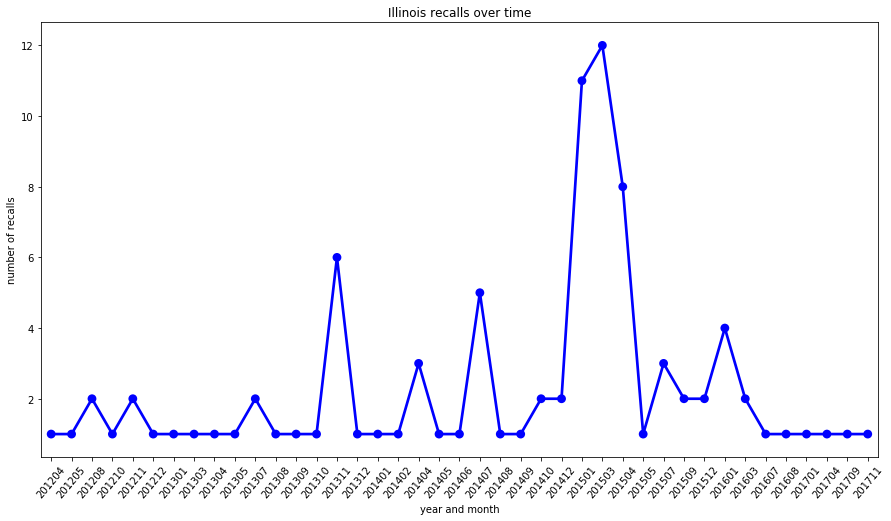

In [232]:
illinois = state_class_recalls(state = "il",pages = 18, drug_class = "Class I")
for i in range(0,len(illinois)):
    illinois.iloc[i,17] = str(illinois.iloc[i,17])
    illinois.iloc[i,17] = illinois.iloc[i,17][0:-2]
#Convert to string so we can slice the day out of the recall initiation date

dates = illinois.iloc[:,17].value_counts()
dates = pd.DataFrame(dates)
dates["date"] = dates.index.values
#Make the data easier to plot

fig, ax =plt.subplots(1,1, figsize=(15,8))
ax = sns.pointplot(x = dates.date, y = dates.recall_initiation_date, color = "blue", fit_reg=True,ax = ax)
ax.set_xticklabels = ax.set_xticklabels(ax.get_xticklabels(), rotation = 50)
ax.set = ax.set(title = "Illinois recalls over time", ylabel = "number of recalls",xlabel = "year and month" )

The above graph shows the number of class 1 recalls in Illinois over the past 5 years and the months that did not have any reported are not included in the graph and the labels are in the format where the year comes first followed by the month.  We can see that there is clearly a spike at the beginning of 2015.  In January there were 11 recalls, in March there were 12 recalls, and in April there were 8 recalls.  To find out the reason for this particular spike in recalls we looked more in depth at the reports for the recalls in that time period.

In [242]:
CSS = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))
#Makes tables display one next to each other as opposed to one on top of the other

In [233]:
crazy_dates1 = illinois.loc[(illinois["recall_initiation_date"]=="201501")]
crazy_dates2 = illinois.loc[(illinois["recall_initiation_date"]=="201503")]
crazy_dates3 = illinois.loc[(illinois["recall_initiation_date"]=="201504")]
crazy_dates = pd.concat([crazy_dates1,crazy_dates2, crazy_dates3])
#Get the reports for those specific months

for i in range(0,len(crazy_dates)):
    crazy_dates.iloc[i,16] = crazy_dates.iloc[i,16][0:30]
#Saw a trend for Presence of Particulate Matter which is 30 characters

reasons = pd.DataFrame(crazy_dates.reason_for_recall.value_counts())
companies = pd.DataFrame(crazy_dates.recalling_firm.value_counts())
companies.columns = ["recalling_firm_special_dates"]
companies_total = pd.DataFrame(illinois.iloc[:,19].value_counts())
#recalling firm and the reason for recall were the most interesting finds from the reports dataframe
display(companies, reasons, companies_total)

,recalling_firm_special_dates
"Pharmedium Services, LLC",16
Mylan Institutional LLC,6
Hospira Inc.,5
Baxter Healthcare Corp.,4


,reason_for_recall
Presence of Particulate Matter,27
Subpotent Drug,2
Labeling: Wrong Bar Code: Ther,1
Non-Sterility: Confirmed custo,1


,recalling_firm
Hospira Inc.,34
Baxter Healthcare Corp.,23
"Pharmedium Services, LLC",18
Mylan Institutional LLC,6
"Hospira Inc., A Pfizer Company",2
Baxter Healthcare Corporation,2
Medline Industries Inc,2
"Mylan Institutional, Inc. (d.b.a. UDL Laboratories)",1
"Consumer Concepts, Inc.",1
Baxter Healthcare Corp,1


After looking more in depth at why Illinois has so many more Class 1 recalls per million than any other state we found a few interesting results which are seen in the tables above. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; First we can see that the reason for these recalls is almost exclusively because there was the presence of particulate matter.  Particulate matter is the sum of all solid and liquid particles suspended in substance many of which are hazardous. This complex mixture includes both organic and inorganic particles, such as dust, pollen, soot, smoke, and liquid droplets.  One such example from one of Pharmedium's recalls was that they found particles of glass in their products, and this is potentially lethal to anyone taking this drug.  Particulate Matter can be a variety of different things, but in the drug industry this is extremely dangerous. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Second, the table on the right shows all of the recalling firms for all of the recalls since 2012 and we can see that Pharmedium Services had pretty much all of their recalls because of this Particulate Matter scare.  This puts Pharmedium down near the bottom of the list for the total number of recalls if we remove that particular scare. However, if I was a regulator and I was seeing this I would continue to make sure that Pharmedium does not have another mass recall because of dangerous substances in their products, because that is a scary amount of potentially deadly recalls from just one firm.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Lastly, Hospira Inc and Baxter Healthcare Corporation account for pretty much all of the class 1 recalls for the entire state since 2012.  Baxter is a Fortune 500 company, and Hospira is a subsidiary of Pfizer Inc. which is in the top 5 pharmaceutical companies in terms of revenue in the US, and is either first or second in revenue globally.  Hospira was bought out by Pfizer in late 2015 and it would be interesting to see if the majority of its recalls are before or after this acquisition.  Baxter deals primarily with hospitals and most of its business comes kidney diseases and dialysis as well as hemophilia and autoimmune disorders.  We would like to dive more into why these two companies in particular have so many recalls but that data is not open to us at the moment.  Below is the recalls after Pfizer acquired Hospira in September of 2015.

In [250]:
hospira = illinois.loc[(illinois["recalling_firm"]=="Hospira Inc.")]
pfizer = hospira.loc[(hospira["recall_initiation_date"]>= "201509")] #09 is September
pd.DataFrame(pfizer.recall_initiation_date.value_counts())

,recall_initiation_date
201603,2
201704,1
201601,1


__Conclusion:__ Looking at all of the recalls and then just the most dangerous ones which are the Class 1 recalls we found that Illinois had an abnormally high number of Class 1 recalls.  When analyzing Illinois we found that there was a spike in the number of recalls in early 2015, and this was attributed to the Presence of Particulate Matter mainly from Pharmedium Services LLC.  Apart from this spike Illinois is inside the range of recalls per million people, although slighly on the higher side.  The reason they are on the higher side is mainly because of two firms, Baxter and Hospira, and from the table above we can see that 30 of Hospira's 34 recalls were before Pfizer acquired them in September of 2015 most likely meaning Pfizer rectified some of the bad trends or got rid of many sectors in Hospira.  As for Baxter we are unsure as to the internal reason for so many recalls as that information is not available.  All in all, each of the states with a high amount of class 1 recalls ranges from 1.5-4.5 recalls per million since 2012 which is not a very high amount, and Illinois has had an unusually high amount which can be largely attributed to one spike in early 2015 and to two particular firms.  

## Second Question Which food industries or products are the least safe?

- See which industries have the most adverse affects
- Which products have the most adverse affects
- Is there any kind of relationship between the two

Below is the first step where we looked at the total number of adverse effect reports since 2004 and we looked at which industries had the most complaints of all

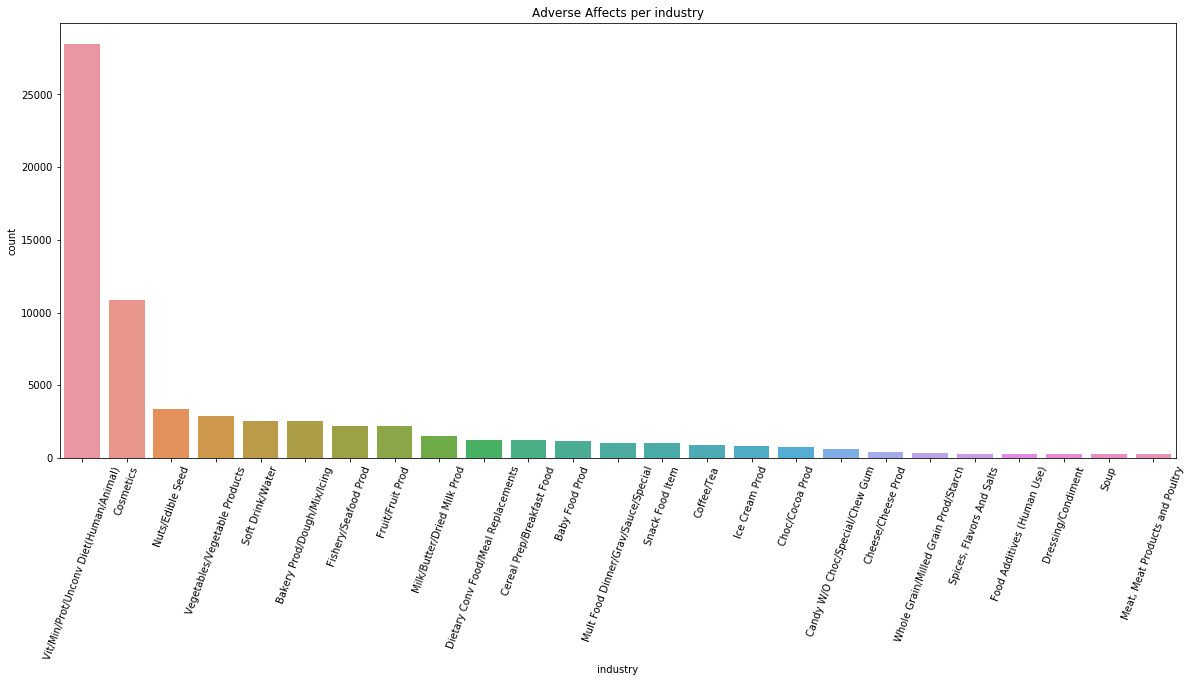

In [266]:
industry_complaints = requests.get("https://api.fda.gov/food/event.json?count=products.industry_name.exact")
industry_comp = industry_complaints.json()
industry_counts = pd.DataFrame(industry_comp["results"])
industry_counts = industry_counts[0:25]
#Get the number of adverse effect reports from each industry

fig, ax =plt.subplots(1,1, figsize=(20,8))
ax = sns.barplot(data = industry_counts, x = "term",y = "count")
ax.set_xticklabels = ax.set_xticklabels(ax.get_xticklabels(), rotation = 70)
ax.set = ax.set(title = "Adverse Affects per industry", xlabel = "industry")

From the above graph we can see that the Vitamin/Mineral/Unconvential Diet industry has the most complaints by far, and cosmetics is second with many more complaints than all the other industries besides the vitamins.  We knew that cosmetics were dangerous, but in comparison to every other industry there are way more negative affect reports in the FDA than for pretty much every food industry.  The next step is to look at these top two industries and see what kind of negative affects are most commonly reported within each industry and see what we find.

In [277]:
#53 and 54 are industry codes for vit/min... and cosmetics
vit_complaints = requests.get("https://api.fda.gov/food/event.json?count=reactions.exact&search=products.industry_code:54")
cosmetics_complaints = requests.get("https://api.fda.gov/food/event.json?search=products.industry_name.exact==cosmetics&count=reactions.exact")
#Using the industry code and name get the complaints from each industry from FDA database

vit_symptoms = vit_complaints.json()
cosmetics_complaints = cosmetics_complaints.json()
vit_symptoms = pd.DataFrame(vit_symptoms["results"])
cosmetics_symptoms = pd.DataFrame(cosmetics_complaints["results"])
vit = vit_symptoms[0:10]
cosmetics = cosmetics_symptoms[0:10]
#Only show the top 10 results for the complaints reported

display(vit,cosmetics)

,count,term
0,4102,CHOKING
1,2240,NAUSEA
2,2229,DYSPNOEA
3,2162,VOMITING
4,1942,DYSPHAGIA
5,1845,DIARRHOEA
6,1687,DIZZINESS
7,1420,HYPERSENSITIVITY
8,1369,HEADACHE
9,1266,PAIN


,count,term
0,4645,OVARIAN CANCER
1,1635,ALOPECIA
2,1157,PRURITUS
3,820,RASH
4,788,BURNING SENSATION
5,701,ERYTHEMA
6,700,HYPERSENSITIVITY
7,553,SWELLING
8,538,PAIN
9,393,BLISTER


The table on the right is the reactions for the cosmetics industry and the one on the left is for the Vitamins/Minerals/Unconventional Diet industry.  We can see that the reactions for the cosmetics industry are much more severe than for the Vitamins industry.  Although choking on a vitamin or mineral pill is no laughing matter, ovarian cancer is extremely dangerous.  Alopecia is hair loss from the scalp or any other part of the body.  After getting these results we will analyze which cosmetic products are causing cancer as that is the most severe of the reactions that is shown.

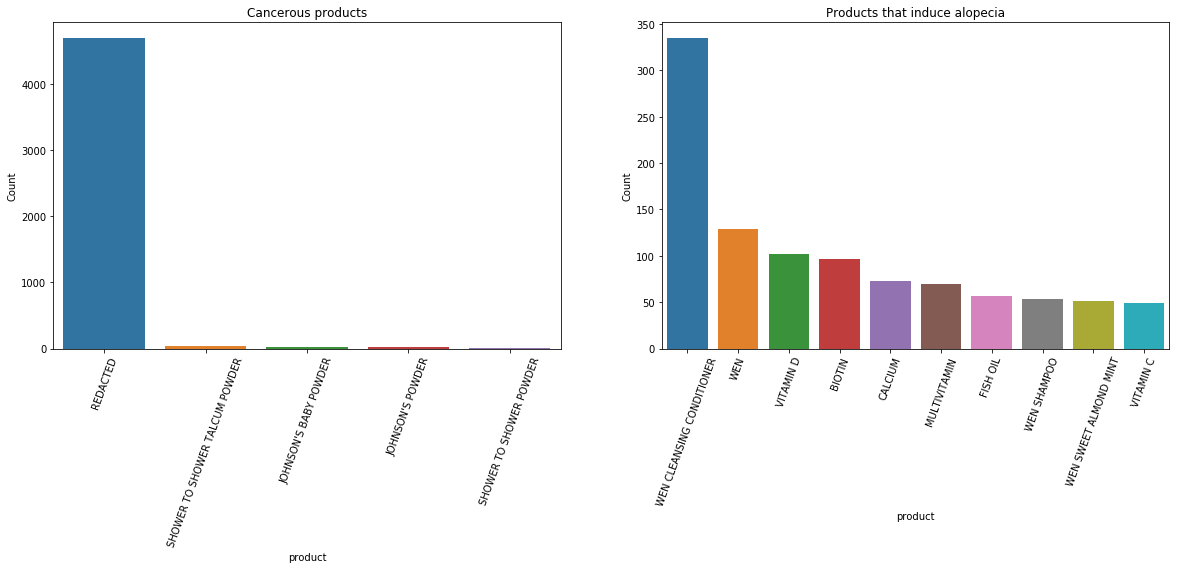

In [304]:
cancer = requests.get("https://api.fda.gov/food/event.json?search=reactions==cancer &count=products.name_brand.exact")
cancer = cancer.json()
cancer = pd.DataFrame(cancer["results"])
cancer = cancer[0:5]
#Get the product names that have to do with cancer

alopecia = requests.get("""https://api.fda.gov/food/event.json?search=reactions==alopecia&count=products.name_brand.exact""")
alopecia = alopecia.json()
alopecia = pd.DataFrame(alopecia["results"])
alopecia = alopecia[0:10]
#alopecia since cancer has so many redacted results

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6))
ax1 = sns.barplot(data = cancer, x = "term", y = "count", ax = ax1)
ax2 = sns.barplot(data = alopecia, x = "term", y = "count", ax = ax2)
ax1.set_xticklabels = ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 70)
ax2.set_xticklabels = ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 70)
ax1.set = ax1.set(title = "Cancerous products", xlabel = "product", ylabel = "Count")
ax2.set = ax2.set(title = "Products that induce alopecia", xlabel = "product", ylabel = "Count")

Unfortunately pretty much every report that had the reaction of just cancer in general the product name was redacted, which means that we need some kind of other authorization in order to see which products had reported causes of ovarian cancer.  This is an unexpected development and we were excited to find out which cosmetics products have these severe reactions.  With the FDA redacting some product names depending on a variety of reason we had to switch up and account for this probability in our further extractions from the FDA database.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; The second graph on the right is the products that caused alopecia, which was the second most complained about reason for the cosmetics industry.  From these results we can see that Wen products caused this problem way more than any other product or company.  Wen is a hair product company and there are a lot of reports of alopecia from them which is pretty worrisome.  We are not sure what exactly is causing this from Wen products, but it is something that we will definitely keep in mind when we see Wen products and looking for hair products in the future.  The next analysis we wanted to look at was what was the number one reacted to product then see what the normal reaction was to that product.

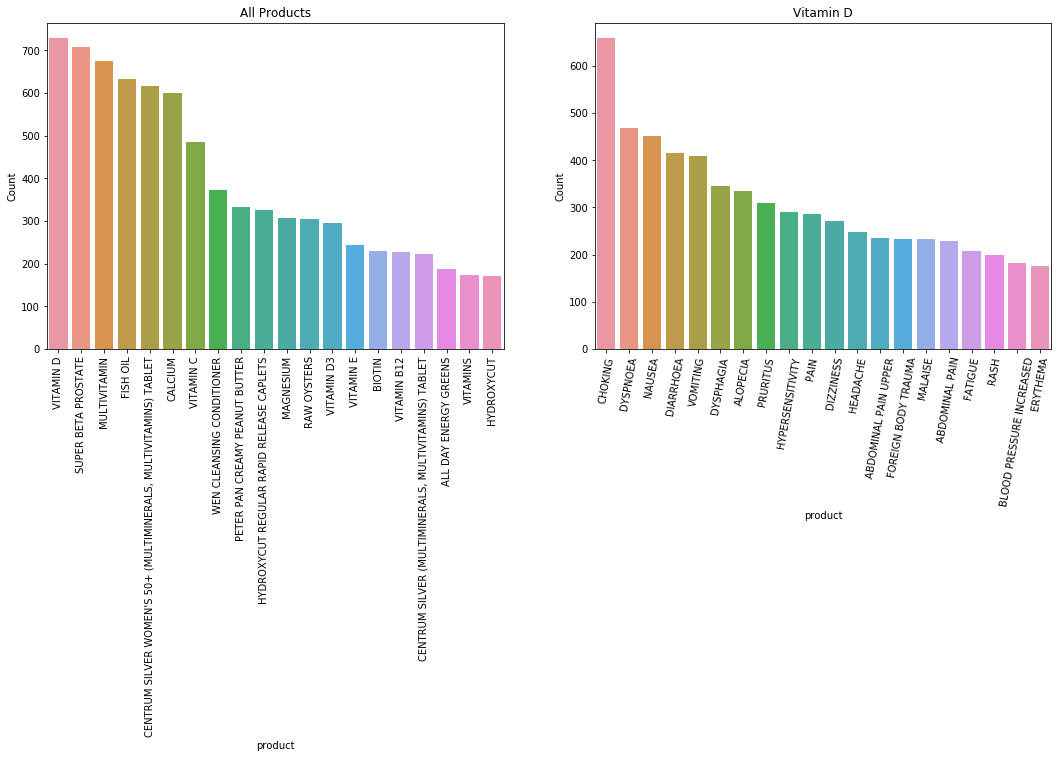

In [319]:
all_products = requests.get("https://api.fda.gov/food/event.json?count=products.name_brand.exact")
all_products = all_products.json()
all_products = pd.DataFrame(all_products["results"])
all_products = all_products[1:21]
#6000 redacted
vitamin_d = requests.get("https://api.fda.gov/food/event.json?search=products.name_brand.exact==vitamin+d &count=reactions.exact")
vitamin_d = vitamin_d.json()
vitamin_d = pd.DataFrame(vitamin_d["results"])
vitamin_d = vitamin_d[0:20]
#vitamin d was the most reacted to product after redacted

fig, ((ax1,ax2)) = plt.subplots(1,2, figsize=(18,6))
ax1 = sns.barplot(data = all_products, x = "term", y = "count", ax = ax1)
ax2 = sns.barplot(data = vitamin_d, x = "term", y = "count", ax = ax2)
ax1.set_xticklabels = ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
ax2.set_xticklabels = ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 80)
ax1.set = ax1.set(title = "All Products", xlabel = "product", ylabel = "Count")
ax2.set = ax2.set(title = "Vitamin D", xlabel = "product", ylabel = "Count")

The graph on the left shows the results for all products and since vitamin d had the most reactions besides redacted product names we found the most common symptoms of vitamin d reactions on the graph to the right.  We must again note that there were about 6000 redacted product names which definitely makes the data mean a lot less than it otherwise would. There are 65,000 total reports which means that about 10% of those have a redacted product name.  It makes sense that vitamin D had a high amount of choking since I'm assuming they come in a pill.

__Conclusion:__ We found that the industries with the most reactions to their products was the vitamins/minerals/unconventional diet industry, and the cosmetics industry.  These two industries are both heavily man made which is a strong reason as to why these two have the most reactions.  Upon further analysis we ran into the problem of having many redacted product names when wanting to find what products were the most likely to cause cancer, but otherwise we saw that Wen products caused a very high number of people to experience and even report loss of hair(alopecia) to the FDA.  We also saw that vitamin d pills are the product that people have the most reactions too, and the principle reaction is choking.  It is unfortunate that we could not get a better answer to our question because of redacted information, but this shows us that although a database can be extremely extensive their can be information that is still missing, incomplete, or redacted.

## Third Question: What drugs do different age groups use, and what kind of drugs are the most dangerous?

In [2]:
source = 'https://api.fda.gov/drug/event.json?'
def fdaSearch(source): 
    fullSearch = source
    drug = requests.get(fullSearch)
    results = drug.json()['results']
    drugDF = pd.DataFrame(results)
    return drugDF

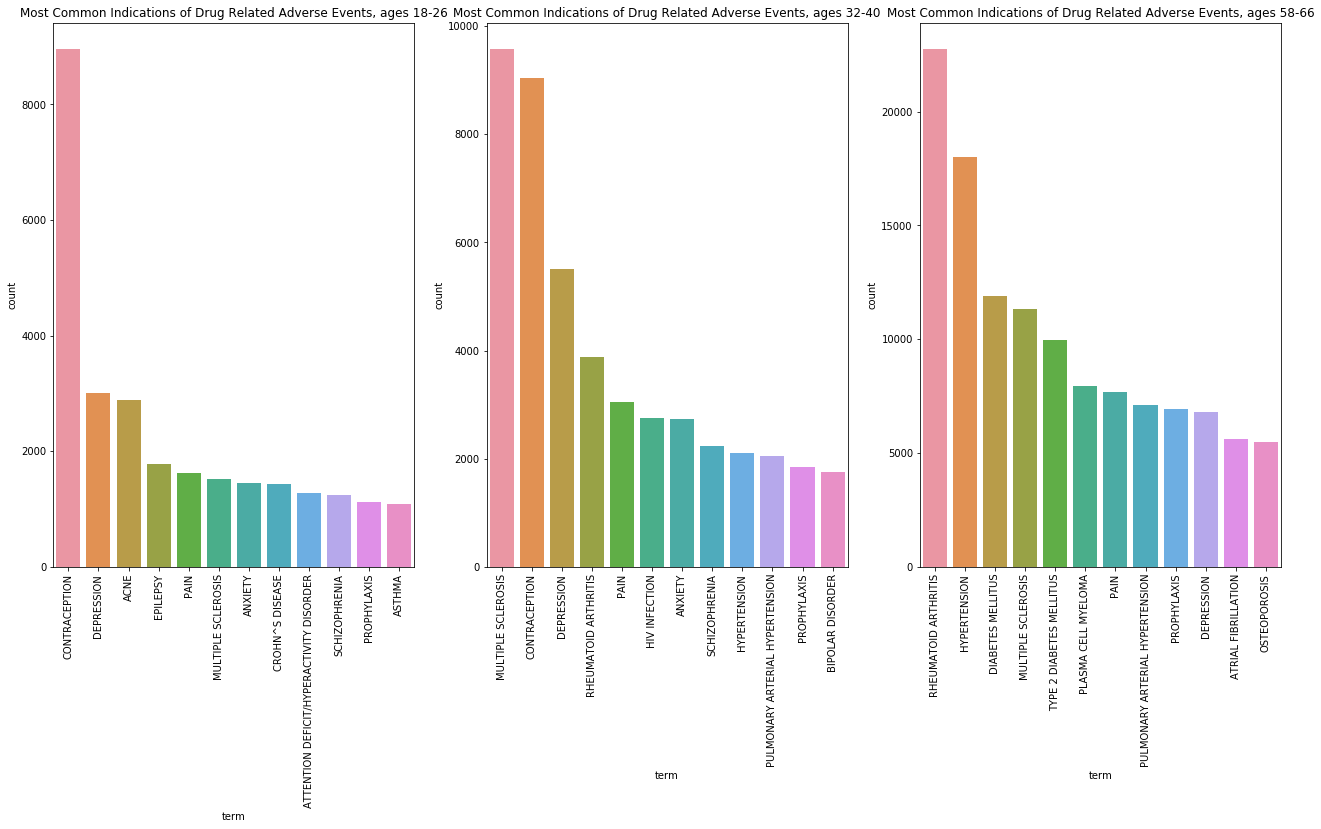

In [3]:
#Drug Indications for young adults aged 17 to 25 that resulted in serious complications
youngBadIndication = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[15+TO+24]&count=patient.drug.drugindication.exact')
youngBadIndicationCount = youngBadIndication.head(n=13)
#Drop PRODUCT USED FOR UNKNOWN INDICATION --> first row
youngBadIndicationCount=youngBadIndicationCount.iloc[1:13]
#Drug Indications for young adults aged 32 to 40 that resulted in serious complications
middleBadIndication = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[32+TO+40]&count=patient.drug.drugindication.exact')
middleBadIndicationCount = middleBadIndication.head(n=13)
middleBadIndicationCount=middleBadIndicationCount.iloc[1:13]
#Drug Indications for young adults aged 58 to 66 that resulted in serious complications
seniorBadIndication = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[58+TO+66]&count=patient.drug.drugindication.exact')
seniorBadIndicationCount = seniorBadIndication.head(n=13)
seniorBadIndicationCount = seniorBadIndicationCount.iloc[1:13]


fig,((ax1,ax2,ax3)) = plt.subplots(1,3,figsize = (22,10))
ax1 = sns.barplot(x = 'term', y = 'count',data = youngBadIndicationCount,ax = ax1)
ax1.set_xticklabels = ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set = ax1.set(title = "Most Common Indications of Drug Related Adverse Events, ages 18-26")

ax2 = sns.barplot(x = 'term', y = 'count',data = middleBadIndicationCount, ax = ax2)
ax2.set_xticklabels = ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90) 
ax2.set = ax2.set(title = "Most Common Indications of Drug Related Adverse Events, ages 32-40")

ax3 = sns.barplot(x = 'term', y = 'count',data = seniorBadIndicationCount, ax=ax3)
ax3.set_xticklabels = ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90) 
ax3.set=ax3.set(title = "Most Common Indications of Drug Related Adverse Events, ages 58-66")

&nbsp;&nbsp;&nbsp;&nbsp;The above barplots show most common indications that resulted in serious drug related adverse events by three ages groups: 18-26, 32-40, and 58-66. These age groups, intervals of 8 years, are useful in reflecting differences in drug usage because it gives a representative overview of how usage changes. Each interval accurately reflects very distinct points in a given patients life and associated medical barriers. Serious outcomes are defined by the FDA as follows: "The adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition"

&nbsp;&nbsp;&nbsp;&nbsp;We chose to only look at data from 2010 and on. The count variable clearly shows that the largest age group of 58-66 has the largest drug usage, which makes sense. As we age we increase our dependencies on pharmaceutical drugs to treat increasingly common disorders and alleviate associated symptoms. As we iterate through each age group, drug usage increases. 

&nbsp;&nbsp;&nbsp;&nbsp;Observing the distribution of indicators for the youngest age group, we see that contraception is by far the most common indication for serious drug reactions. Contraception is also the most common indicator for drugs total amongst this age group so that is not suprisingly. It is intersting, as generally only females will be prescribed birth control at this age so the fact it has a count of nearly 9000 and the next most common indicator, depression, is at 3000 shows that pharmaceutical drug use is not abundant compared to the other ages.

&nbsp;&nbsp;&nbsp;&nbsp;When subsetting by age group, we can see some interesting trends that reflect greatly upon the causes for pharmaceutical drug usage amongst that particular group. The most common indication for the youngest age group is unsurprsingly contraception, followed by depression, and acne. These are all customary issues than young adults face, and the drugs used in treating them have caused the most severe outcomes.  The indication that the youngest age group faces that the other groups do not is in treating ADHD. Either the treatment of ADHD is most common in the youngest age groups, or they are the most prone to negative outcomes associated with the drugs prescribed. Pain is the commonality across all age groups, predictably. Across the first two age groups, anxiety is the 7th most common indication that resulted in some drug related adverse event. When moving on to the oldest group, anxiety does not appear among the top 12 indicators. Depression is 2nd in indications for the youngest group, moving down to 3rd in te second group, and 10th in the oldest group. Ages 32-40 showed a particularly high amount of adverse events for the indication of multiple sclerosis, overtaking contraception. HIV and rheumatoid arthiritis also appear at this age interval, which reflect new challenges that this age group faces. The highest age group moves away from mental disorders and behavioral disorders and common drug indicators of adverse events, instead moving to rather serious medical conditions such as hypertension, arthirits, diabetes, meloma, and osteoporosis.

In [4]:
#overall frequent brand drug names that caused serious complications in all age grouos (ibuprofen)
youngBadGenericDrug = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+serious:1&count=patient.drug.openfda.brand_name.exact')
#most frequent Brand drug names that caused serious complications in people aged 18-26
youngBadGenericDrug = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[17+TO+25]&count=patient.drug.openfda.brand_name.exact')
youngBadGenericDrug= youngBadGenericDrug.head(n = 12)
#most frequent Brand drug names that caused serious complications in people aged 32 to 40
middleBadGenericDrug= fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[32+TO+40]&count=patient.drug.openfda.brand_name.exact')
middleBadGenericDrug = middleBadGenericDrug.head(n=12)
#most frequent Brand drug names that caused serious complications in people aged 58 to 66
seniorBadGenericDrug= fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[58+TO+66]&count=patient.drug.openfda.brand_name.exact')
seniorBadGenericDrug = seniorBadGenericDrug.head(n=12)

display_side_by_side(youngBadGenericDrug,middleBadGenericDrug,seniorBadGenericDrug)

,count,term
0,5534,YAZ
1,5245,MIRENA
2,4576,YASMIN
3,4106,PAIN RELIEF
4,3068,MOTRIN INFANTS
5,2885,ADVIL
6,2744,ADVIL LIQUI-GELS
7,2713,CHILDRENS MOTRIN
8,2678,MOTRIN IB
9,2678,CHILDRENS ADVIL


&nbsp;&nbsp;&nbsp;&nbsp;The above dataframes display most common drugs, in terms of brand name, that resulted in serious complications, again split by the above three age groups. The top right table is the youngest age group, the top right table is the mid-life age group, and the bottom left table it the older/seniors age group.  Yaz is a common birth control medication which records high counts amongst the first two age groups. Mirena is also a birth control device, which caused high frequencies of serious complications. In the youngest age group, pain relief and non steroidal anti inflammatories (such as ibuprofen,advil,aspirin etc.) caused the majority of complications. Clearly blood thinners, fever reducers, and anti inflammatories are dangerous medications when abused or overused, and compile the vast majority of adverse event reports to the FDA. The dangers of these drugs are well documented. Xanax is a common drug in the midle age group that resulted in adverse events, which is not surprisingly considering the risk of abuse or addiction for anti anxiety medications. Enbrel is used to treat arthiritis and seems to be a particularly dangrous drug.

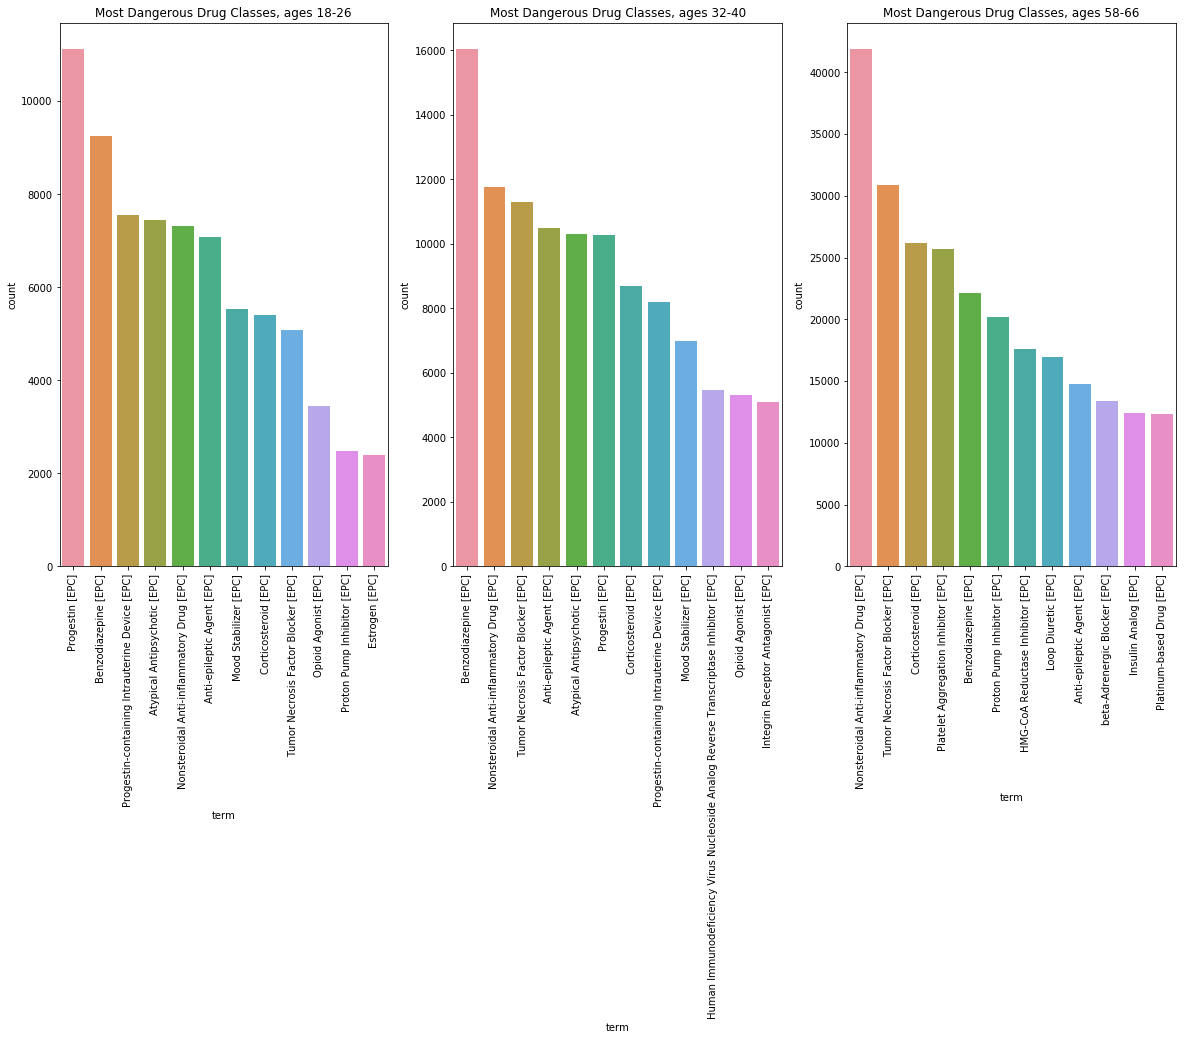

In [5]:
#Dangerous Drug Classes for young adults aged 18 to 26
youngDangClasses = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[18+TO+26]&count=patient.drug.openfda.pharm_class_epc.exact')
youngDangClasses = youngDangClasses.head(n=12)                             
#Dangerous Drug Classes for young adults aged 32 to 40
middleDangClasses = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[32+TO+40]&count=patient.drug.openfda.pharm_class_epc.exact')
middleDangClasses = middleDangClasses.head(n=12)  
#Dangerous Drug Classes for young adults aged 58 to 66
seniorDangClasses = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20180316]+AND+serious:1+AND+patient.patientonsetage:[58+TO+66]&count=patient.drug.openfda.pharm_class_epc.exact')
seniorDangClasses = seniorDangClasses.head(n=12)

fig,((ax1,ax2,ax3)) = plt.subplots(1,3,figsize = (20,10))
ax1 = sns.barplot(x = 'term', y = 'count',data = youngDangClasses,ax = ax1)
ax1.set_xticklabels = ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set = ax1.set(title = "Most Dangerous Drug Classes, ages 18-26")

ax2 = sns.barplot(x = 'term', y = 'count',data = middleDangClasses, ax = ax2)
ax2.set_xticklabels = ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90) 
ax2.set = ax2.set(title = "Most Dangerous Drug Classes, ages 32-40")

ax3 = sns.barplot(x = 'term', y = 'count',data = seniorDangClasses, ax=ax3)
ax3.set_xticklabels = ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90) 
ax3.set=ax3.set(title = "Most Dangerous Drug Classes, ages 58-66")

&nbsp;&nbsp;&nbsp;&nbsp;The above barcharts show another perspective on the adverse drug event data. They display most abused or dangerous drug classes amongst the three age groups. This is imported information to analyze because it can point to classes of drugs that probably should be prescribed less, or taken with more caution amongst each age group. The class of progestin is that of birth control and is consistent with the rest of the collected data. Benzodiaepines, a class of drugs used as anti anxiety medication, are clearly an extremely dangerous class of drugs. An interesting class reported for the youngest group is "Atypical Antipsychotics", which are defined as major tranquilizers used to treat psychotic disorders. Mood stabilizers, such as antidepressants, are very problematic and it shows that treatments associated with mental or behavioral disorders are quite suspicious in terms of their effects on the younger age groups. Severe outcomes associated with antiinflammatory drugs jumps above 40,000 occurances at the oldest age group, suggesting that the older age groups are more at risk when using such drugs.

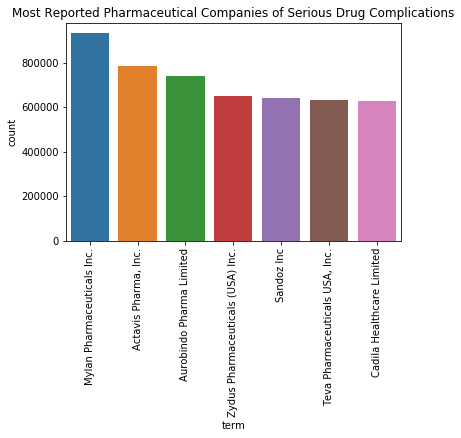

In [7]:
reportPharm = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+serious:1&count=patient.drug.openfda.manufacturer_name.exact')
reportPharmCount = reportPharm.head(n = 7)
dangPharm = sns.barplot(x = 'term', y = 'count',data = reportPharmCount)
dangPharm.set_xticklabels = dangPharm.set_xticklabels(dangPharm.get_xticklabels(),rotation=90) 
dangPharm.set=dangPharm.set(title = "Most Reported Pharmaceutical Companies of Serious Drug Complications")

&nbsp;&nbsp;&nbsp;&nbsp;The above barchart shows the most reported Pharmaceutical Companies in terms of serious complications reported. This chart does not necessarily account for the size of these companies, so if one company has an extremely large market share relative to the other companies that may explain higher appearances on the FDA databases. In order to remedy this potential bias, we researched largest generic drug companies. From the image below displaying the largest generic drug companies by revenue in 2016, we see that Mylan, which by far has the most adverse drug reports reported since 2010, is the second largest company. Teva, the top company by earnings, is ranked 6th, with nearly 300,000 more cases reported. This suggests that Mylan is producing drugs that result in adverse results at a much higher rate than companies of similar sizes.

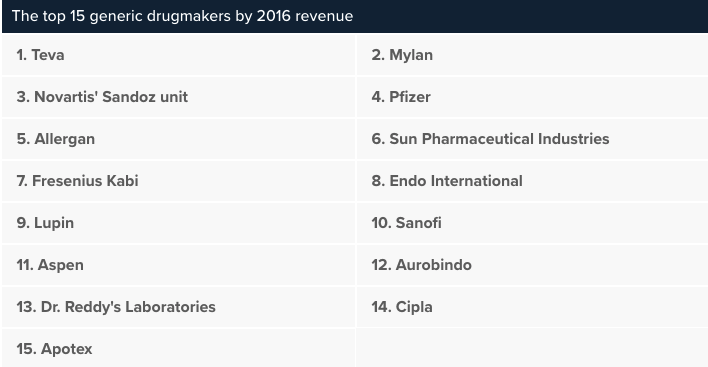

In [15]:
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "drugPic.png"
pic = Image(filename = PATH,width=600, height=600)
pic

In [10]:
import warnings
warnings.simplefilter('ignore')
#Benzo
benzo = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+patient.drug.openfda.pharm_class_epc.exact==benzodiazepine&count=serious')
benzo.iloc[0,1] = 'Serious'
benzo.iloc[1,1] = 'Not Serious'
#Chemo
chemo = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+patient.drug.openfda.pharm_class_epc.exact==chemotherapy&count=serious')
chemo.iloc[0,1] = 'Serious'
chemo.iloc[1,1] = 'Not Serious'
#Painkillers - morphine
opiate = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+patient.drug.openfda.pharm_class_epc.exact=morphine&count=serious')
opiate.iloc[0,1] = 'Serious'
opiate.iloc[1,1] = 'Not Serious'
#amphetamines
amph = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+patient.drug.openfda.pharm_class_epc.exact==amphetamine&count=serious')
amph.iloc[0,1] = 'Serious'
amph.iloc[1,1] = 'Not Serious'



display_side_by_side(benzo,chemo,opiate,amph)

,count,term
0,170532,Serious
1,80475,Not Serious
,count,term
0,19126,Serious
1,1491,Not Serious
,count,term
0,41407,Serious
1,12998,Not Serious
,count,term
0,12533,Serious


&nbsp;&nbsp;&nbsp;&nbsp;The above charts show the counts of serious and not serious outcomes by some commonly known dangerous drug classes, such as benzodiazepines(upper left table), chemotherapy drugs(middle top table), opiates (searched as "morhpine", top right table), and amphetamines(bottom left table). Clearly chemotherapy results in the highest frequency of serious reactions with a percentage of 93% of the time it being serious, but that more points to the pre existing condition of a cancer diagnosis than the reactions being attributed to the drug exclusively. However, they are still extremely dangeorus and destructive drugs on the body, evidently. Benzos and Opaites are similarly dangerous, with serious rates of 68% and 76%, respectively. Amphetamines are not as immediately risky, at a serious rate of 60%, albeit with a much smaller sample size.

In [12]:
#benzo
benzoOutcome = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+patient.drug.openfda.pharm_class_epc.exact==BENZODIAZEPINE&count=patient.reaction.reactionoutcome')
benzoOutcome.term[1] = 'Resolved'
benzoOutcome.term[2] = 'Not Resolved'
benzoOutcome.term[3] = 'Fatal'
benzoOutcome.term[4] = 'Recovering'
benzoOutcome = benzoOutcome.iloc[1:5]
benzoOutcome.columns = ["Count","Outcome"]
#Chemotherapy
chemoOutcome = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+patient.drug.openfda.pharm_class_epc.exact==CHEMOTHERAPY&count=patient.reaction.reactionoutcome')
chemoOutcome.term[1] = 'Resolved'
chemoOutcome.term[2] = 'Not Resolved'
chemoOutcome.term[3] = 'Fatal'
chemoOutcome.term[4] = 'Recovering'
chemoOutcome = chemoOutcome.iloc[1:5]
chemoOutcome.columns = ["Count","Outcome"]
#Opiods
opiateOutcome = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+patient.drug.openfda.pharm_class_epc.exact==morphine&count=patient.reaction.reactionoutcome')
opiateOutcome.term[1] = 'Resolved'
opiateOutcome.term[2] = 'Not Resolved'
opiateOutcome.term[3] = 'Fatal'
opiateOutcome.term[4] = 'Recovering'
opiateOutcome = chemoOutcome.iloc[0:5]
opiateOutcome.columns = ["Count","Outcome"]
#amphetamines
amphOutcome = fdaSearch('https://api.fda.gov/drug/event.json?search=receivedate:[20100101+TO+20180316]+AND+patient.drug.openfda.pharm_class_epc.exact==amphetamine&count=patient.reaction.reactionoutcome')
amphOutcome.term[1] = 'Resolved'
amphOutcome.term[2] = 'Not Resolved'
amphOutcome.term[3] = 'Fatal'
amphOutcome.term[4] = 'Recovering'
amphOutcome = amphOutcome.iloc[1:5]
amphOutcome.columns = ["Count","Outcome"]

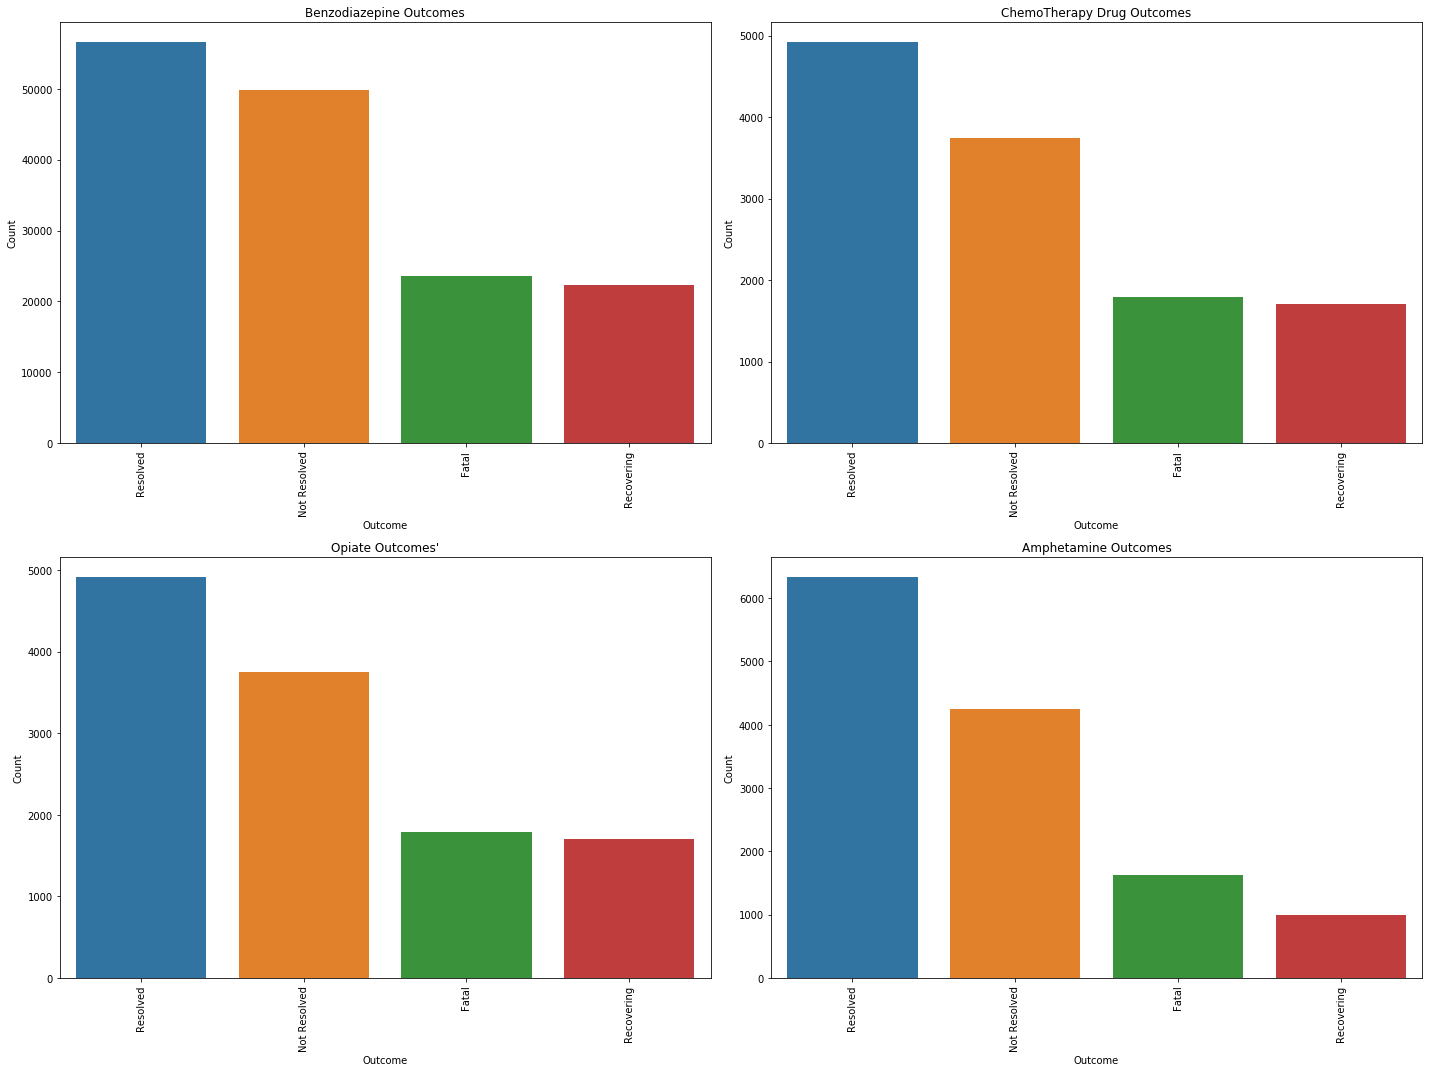

In [17]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize = (20,15))

ax1 = sns.barplot(x = 'Outcome',y='Count', data = benzoOutcome, ax = ax1)
ax1.set_xticklabels = ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax1.set = ax1.set(title = "Benzodiazepine Outcomes")

ax2 = sns.barplot(x = 'Outcome',y='Count', data = chemoOutcome, ax = ax2)
ax2.set_xticklabels = ax2.set_xticklabels(ax1.get_xticklabels(),rotation=90)
ax2.set = ax2.set(title = "ChemoTherapy Drug Outcomes")

ax3 = sns.barplot(x = 'Outcome',y='Count', data = opiateOutcome, ax = ax3)
ax3.set_xticklabels = ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)
ax3.set = ax3.set(title = "Opiate Outcomes'")
                  
ax4 = sns.barplot(x = 'Outcome',y='Count', data = amphOutcome, ax = ax4)
ax4.set_xticklabels = ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)
ax4.set = ax4.set(title = "Amphetamine Outcomes")
plt.tight_layout()

&nbsp;&nbsp;&nbsp;&nbsp;The above barcharts display the most breakdown of outcomes for the above four drug classes. The most fatal drug class is easily the benzo class. Chemotherapy drugs were also quite fatal relative to the total amount of occurances returned in the database. Although the sample sizes vary across the four classes, we can compare them succesfully by comparing the relative size of each barplot. Amphetamines proved to be the least fatal of the four, with the most resolved cases.

__Conclusion:__ Different age groups are affected most often by many different types of drugs.  The youngest age group(18-26) tend to have the most issues with drugs for birth control as well as depression medication.  The middle age group (32-40) still has many adverse reports of birth control, anti anxiety/depression drugs, and pain relievers.  The senior age group (58-66) has way more cases of drug abuse indicating more drug use in general, primarily pain relievers, enbrel(arthritis medication), and anti-inflammatory medicines including aspirin.  Of manufacturers it appears the Mylan is producing drugs that have a negative affect at a much higher rate than other producers of its size.  Of the four drug classes (chemotherapy, opiates, benzodiazepine, and amphetamine) chemotherapy has the most frequency of reports where there is a serious negative reaction but this makes sense as it is a medication for an extremely serious sickness.  Lastly, benzos are the most fatal drug which means that the abuse of pain killers is very common and more often than other classes causes overdoses leading to death.  